In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from os.path import join
from os import listdir
from pprint import pprint

from pandas import DataFrame
# import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

from data_loading import load_csv_files
from utils import get_winter

In [3]:
data = load_csv_files(*[join('data', f) for f in listdir('data') if f.endswith('.csv')])

In [4]:
df = DataFrame(data).transpose()
df.index.name = 'date'
df.reset_index(inplace=True)
# remove the days where we probably did not heat
df = df[df['temp'] < 10]
# add the winter
df['winter'] = df['date'].apply(lambda date: get_winter(date))
df.head()
all_df = df.copy()

In [5]:
# alt.Chart(df, width=500, height=500).mark_point().encode(
#     y='kwh',
#     x='temp',
#     color='winter:N',
# )

In [6]:
# sns.lmplot(data=all_df, x='temp', y='kwh', hue='winter', size=10)

In [7]:
# Fit the curve ourselves
from statsmodels.formula.api import ols
winters = all_df['winter'].unique()
dfs = [all_df[all_df['winter'] == w] for w in winters]
models = [ols('kwh ~ temp', data=df).fit() for df in dfs]
for winter, df in zip(winters, dfs):
    print('Winter {}'.format(winter))
    print('From {} to {}'.format(df['date'].min(), df['date'].max()))
    print()

Winter 2017
From 2016-10-10 to 2017-03-30

Winter 2018
From 2017-10-16 to 2018-03-27



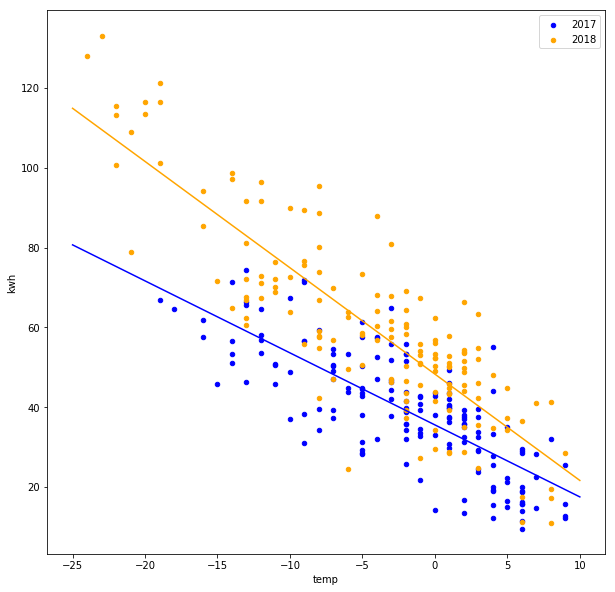

In [8]:
colors = ['blue', 'orange', 'green']
assert len(winters) <= len(colors), 'We did not plan enough colors!'

linspace = np.linspace(-25, 10, 36)
    
fig, ax = plt.subplots(figsize=(10, 10))
for df, color, winter, model in zip(dfs, colors, winters, models):
    df.plot(kind='scatter', x='temp', y='kwh', label=str(winter), ax=ax, color=color)
    ys = model.predict(exog={'temp': linspace})
    ax.plot(linspace, ys.values, color=color)

In [9]:
LOW_RATE = 5.92 / 100.
HIGH_RATE = 9.12 / 100.
LIMIT = 33

def calculate_price(kwhs, low_rate=LOW_RATE, high_rate=HIGH_RATE, limit=LIMIT):
    first_kwh = np.minimum(limit, kwhs)
    price_first_kwh = first_kwh * low_rate
    after_kwh = kwhs - first_kwh
    price_after_kwh = after_kwh * high_rate
    return price_first_kwh + price_after_kwh

In [10]:
for w, df in zip(winters, dfs):
    print('Winter {}'.format(w))
    print('Nb days: {}'.format(len(df)))
    print('Total kwh: {}'.format(df['kwh'].sum()))
    print('Price: {:.2f}$'.format(calculate_price(df['kwh'].values).sum()))
    print()

idx_from = 0
idx_to = 1
theoretical = models[idx_from].predict(exog=dfs[idx_to]['temp']).values
theoretical_sum = theoretical.sum()
print("Using the formlula from {}, we should have needed {} kwh in {}".format(
winters[idx_from], theoretical_sum, winters[idx_to]))
print('Whice means a price of {:.2f}$'.format(calculate_price(theoretical).sum()))

Winter 2017
Nb days: 162
Total kwh: 6363.06
Price: 426.62$

Winter 2018
Nb days: 149
Total kwh: 8989.87
Price: 666.75$

Using the formlula from 2017, we should have needed 6514.3383634542315 kwh in 2018
Whice means a price of 441.77$
